# Introdução:

Análise de Dataset: Letras de Músicas

Este notebook compõe uma série de notebooks que tem como objetivo explorar e aplicar técnicas de NLP sobre o dataset `song_lyrics.csv`, conforme solicitado na prova prática para o CAEd.


# Configuração

In [ ]:
!pip install pyvis --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.3 MB/s eta 0:00:00


In [ ]:
!pip install unidecode --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install thefuzz --quiet

In [ ]:
# Bibliotecas necessárias
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re

# Tarefa (d)
import networkx as nx
import community as community_louvain
from itertools import combinations
from pyvis.network import Network
from unidecode import unidecode
from thefuzz import fuzz

# Baixando Dataset do Drive com gdown e extraindo zip
Link do Dataset: https://drive.google.com/file/d/13T_SXgmSh9qGS2MJXZqQL6BQjfMs4S3c/view?usp=sharing

In [ ]:
# Baixar com gdown
!gdown 13T_SXgmSh9qGS2MJXZqQL6BQjfMs4S3c

# Descompactar
with zipfile.ZipFile('dataset - letras.zip', 'r') as zip_ref:
    zip_ref.extractall('letras_dataset')

# Verificar arquivos
!ls letras_dataset

Downloading...
From (original): https://drive.google.com/uc?id=13T_SXgmSh9qGS2MJXZqQL6BQjfMs4S3c
From (redirected): https://drive.google.com/uc?id=13T_SXgmSh9qGS2MJXZqQL6BQjfMs4S3c&confirm=t&uuid=28400186-a8ea-4658-a7a2-28a4a1e49364
To: /content/dataset - letras.zip
100% 3.26G/3.26G [00:39<00:00, 81.9MB/s]
song_lyrics.csv


# Leituras

Caso a `amostra_song_lyrics10.csv` já exista e esteja incluída no ambiente. Basta pular para a etapa de pré-processamento. A etapa já carrega a base de forma processada, evitando passos extras.

## Opção 1: Amostra criada anteriormente

In [ ]:
# Deve-se subir a amostra para o ambiente do colab. O nome do arquivo deve estar na variável path entre aspas
path = 'amostra_song_lyrics10.csv'
df = pd.read_csv(path)
df.head()

title  tag            artist  year  views  \
0                Ducky  rap  North Star (USA)  2004    143   
1  The Heist Revisited  rap             Big L  2000   5204   
2     Chinese New Year  rap            Clipse  2006  22502   
3      Pop That Cannon  rap           Cassidy  2004    677   
4        Been This Way  rap            Scribe  2003   1014   

                            features  \
0  {"Meko the Pharaoh",Christbearer}   
1                                 {}   
2            {"Roscoe P. Coldchain"}   
3         {"Styles P","Swizz Beatz"}   
4                                 {}   

                                              lyrics language  
0  "Oh you'll love her" (repeats all throughout)\...       en  
1  [Big L]\nYeah, yeah\nYeah-yeah, yeah-yeah-yeah...       en  
2  [Chorus: Pusha T & Pharrell]\nI'm at your door...       en  
3  [Intro - Swizz Beatz]\nAooow! banger, let's go...       en  
4  [Intro]\nEvery MC in this industry wants one t...       en

## Opção 2: Lendo com chuncksize e criando amostra

In [ ]:
# Caminho do CSV
csv_path = 'letras_dataset/song_lyrics.csv'

# Colunas desejadas
usecols = ['title', 'tag', 'artist', 'year', 'views', 'features', 'lyrics', 'language']

# Parâmetros
chunksize = 50_000  # número de linhas por chunk
sample_frac = 0.1   # fração da amostra por chunk (10%)

# Lista para armazenar amostras
samples = []

# Leitura por chunks
for chunk in pd.read_csv(csv_path, usecols=usecols, chunksize=chunksize):
  sample = chunk.sample(frac=sample_frac, random_state=42)
  samples.append(sample)

# Concatenar todos os pedaços amostrados
df = pd.concat(samples).reset_index(drop=True)

# Visualizar forma e colunas
print(f"Total de linhas na amostra: {df.shape[0]}")
df.head()

# Salva a amostra reduzida
df.to_csv('amostra_song_lyrics10.csv', index=False)
print("Arquivo salvo como amostra_song_lyrics10.csv")

Total de linhas na amostra: 513486
Arquivo salvo como amostra_song_lyrics.csv


# Pré-processamento

## Remoção de Livros e Poemas

In [ ]:
# Configurações
path = 'amostra_song_lyrics10.csv'
chunksize = 10000
limite_palavras_livro = 2000

# Contadores
total_entradas = 0
removidos_livros = 0
removidos_poemas = 0
exemplos_livros = []
exemplos_poemas = []
entradas_mantidas = []

# Função para detectar poemas
def analisar_estrutura(letra):
  if not isinstance(letra, str) or not letra.strip():
    return False

  linhas = [linha.strip() for linha in letra.split('\n') if linha.strip()]
  if len(linhas) < 8:
    return False

  total_linhas = len(linhas)
  palavras = ' '.join(linhas).split()
  diversidade = len(set(palavras)) / len(palavras) if palavras else 0
  media_palavras = len(palavras) / total_linhas
  linhas_repetidas = total_linhas - len(set(linhas))
  proporcao_repetidas = linhas_repetidas / total_linhas
  linhas_curtas = [linha for linha in linhas if len(linha.split()) < 7]
  proporcao_curtas = len(linhas_curtas) / total_linhas

  # Filtros básicos
  if media_palavras < 4 or diversidade < 0.3:
      return False

  # Score poético
  score_poetico = proporcao_curtas * (1 - proporcao_repetidas)

  return score_poetico >= 0.6

# Leitura por partes
for chunk in pd.read_csv(path, usecols=['title', 'tag', 'artist', 'year', 'features', 'views', 'lyrics', 'language'], chunksize=chunksize):
  chunk.dropna(subset=['lyrics'], inplace=True)
  total_entradas += len(chunk)

  # Detectar livros
  chunk['len_lyrics'] = chunk['lyrics'].str.split().apply(len)
  filtro_livros = chunk['len_lyrics'] > limite_palavras_livro
  livros = chunk[filtro_livros]
  if len(exemplos_livros) < 2:
    exemplos_livros.extend(livros[['title', 'artist', 'len_lyrics', 'lyrics']].head(2).to_dict('records'))
  removidos_livros += len(livros)

  # Restante
  chunk = chunk[~filtro_livros]

  # Detectar poemas nas tags relevantes
  chunk.loc[:, 'tag'] = chunk['tag'].astype(str).str.lower()
  filtro_tag_poema = chunk['tag'].isin(['misc', 'other'])

  poemas_idx = []
  for idx, row in chunk[filtro_tag_poema].iterrows():
    if analisar_estrutura(row['lyrics']):
      poemas_idx.append(idx)
      if len(exemplos_poemas) < 2:
        exemplos_poemas.append({
          'title': row['title'],
          'artist': row['artist'],
          'score_poetico': '≈ estrutural',
          'lyrics': row['lyrics']
        })

  removidos_poemas += len(poemas_idx)
  chunk = chunk.drop(poemas_idx)

  # (opcional) salvar para uso posterior
  entradas_mantidas.append(chunk)

# Concatenar final se desejar
df = pd.concat(entradas_mantidas, ignore_index=True)

# Relatório
print("Relatório de Limpeza:")
print(f"Total de entradas analisadas: {total_entradas}")
print(f"Entradas removidas (livros): {removidos_livros}")
print(f"Entradas removidas (poemas): {removidos_poemas}")
print(f"Total removido: {removidos_livros + removidos_poemas}")
print(f"Total final mantido: {len(df)}")

print("\nExemplos removidos (livros):")
for e in exemplos_livros:
  print(f" - {e['title']} ({e['artist']}) | {e['len_lyrics']} palavras")
  print(f"Trecho:\n{e['lyrics'][:300]}\n")

print("\nExemplos removidos (poemas):")
for e in exemplos_poemas:
  print(f" - {e['title']} ({e['artist']})")
  print(f"Trecho:\n{e['lyrics'][:300]}\n")

Relatório de Limpeza:
Total de entradas analisadas: 513486
Entradas removidas (livros): 2488
Entradas removidas (poemas): 2960
Total removido: 5448
Total final mantido: 508038

Exemplos removidos (livros):
 - Paradise Lost Book 9 (John Milton) | 9030 palavras
Trecho:
No more of talk where God or Angel guest
With Man, as with his friend, familiar us'd
To sit indulgent, and with him partake
Rural repast; permitting him the while
Venial discourse unblam'd. I now must change
Those notes to tragick; distrust, and breach
Disloyal on the part of Man, revolt
And disobed

 - Rappers Delight (Sugarhill Gang) | 3195 palavras
Trecho:
[Chorus: Wonder Mike]
I said a hip-hop, the hippie, the hippie
To the hip, hip-hop and you don't stop the rockin'
To the bang-bang boogie, say up jump the boogie
To the rhythm of the boogie, the beat

[Verse 1: Wonder Mike]
Now, what you hear is not a test, I'm rapping to the beat
And me, the groove


Exemplos removidos (poemas):
 - The Tyger (William Blake)
Trecho:
T

## Limpeza do campo features

In [ ]:
df = df[['artist', 'features']]
df.head()

artist                           features
0  North Star (USA)  {"Meko the Pharaoh",Christbearer}
1             Big L                                 {}
2            Clipse            {"Roscoe P. Coldchain"}
3           Cassidy         {"Styles P","Swizz Beatz"}
4            Scribe                                 {}

In [ ]:
def limpar_features(feat_str):
  if not isinstance(feat_str, str) or feat_str.strip() == '{}':
    return ''

  # Remove chaves
  feat_str = feat_str.strip('{}')

  # Remove aspas e espaços extras de cada nome
  feat_str_limpo = ','.join(
    re.sub(r'^"|\'|"$|\'$', '', nome.strip()) for nome in feat_str.split(',') if nome.strip()
  )
  return feat_str_limpo

# Aplicar limpeza no campo 'features'
df['features'] = df['features'].apply(limpar_features)

In [ ]:
df.head()

artist                       features
0  North Star (USA)  Meko the Pharaoh,Christbearer
1             Big L                               
2            Clipse            Roscoe P. Coldchain
3           Cassidy           Styles P,Swizz Beatz
4            Scribe

## Tarefa (d): Rede de Colaboração

Objetivo: criar grafo de colaboração de artistas

In [ ]:
# Extrair colaborações
pares_colaborativos = []

for _, row in df.iterrows():
  artista_principal = row['artist']

  # Verifica se há features e separa nomes
  if pd.notna(row['features']):
    # Assume que os artistas em 'features' estão separados por vírgula
    colaboradores = [feat.strip().title() for feat in row['features'].split(',') if feat.strip()]

    # Gera os pares: principal ↔ cada colaborador
    for colaborador in colaboradores:
      if colaborador != artista_principal:
        pares_colaborativos.append((artista_principal.title(), colaborador))

In [ ]:
# Contagem dos pares
contagem_colabs = Counter(pares_colaborativos)
print(contagem_colabs)

Counter({('Genius Brasil Tradues', 'Genius Brasil Traduções'): 889, ('Genius Traducciones Al Espaol', 'Genius Traducciones Al Español'): 680, ('Genius Traductions Franaises', 'Genius Traductions Françaises'): 463, ('Genius Trke Eviri', 'Genius Türkçe Çeviri'): 404, ('Genius Russian Translations ( )', 'Genius Russian Translations (Русский Перевод)'): 328, ('Genius Deutsche Bersetzungen', 'Genius Deutsche Übersetzungen'): 173, ('Polskie Tumaczenia Genius', 'Polskie Tłumaczenia Genius'): 138, ('La Bible De Jrusalem', 'La Bible De Jérusalem'): 118, ('Genius Farsi Translations ( )', 'Genius Farsi Translations (ترجمه\u200cی فارسی)'): 117, ('  (Leo Tolstoy)', 'Лев Толстой (Leo Tolstoy)'): 91, ('Nat "King" Cole', 'Nat \\\\\\"King\\\\\\" Cole'): 82, ('Curren$Y', 'Curren\\\\$Y'): 74, ('Motrhead', 'Motörhead'): 58, ('The Fall', '\u200bThe Fall'): 52, ('Die Rzte', 'Die Ärzte'): 50, ('Roco Jurado', 'Rocío Jurado'): 48, ('Franoise Hardy', 'Françoise Hardy'): 45, ('Of Montreal', '\u200bOf Montreal'):

In [ ]:
# Contruir Grafo
G = nx.Graph()

for (a1, a2), peso in contagem_colabs.items():
  G.add_edge(a1, a2, weight=peso)

print(f"Número de nós (artistas): {G.number_of_nodes()}")
print(f"Número de arestas (colaborações): {G.number_of_edges()}")

Número de nós (artistas): 132799
Número de arestas (colaborações): 107849


## Análise do Grafo

In [ ]:
# Grau médio
graus = dict(G.degree())
grau_medio = sum(graus.values()) / len(graus)
print(f"Grau médio: {grau_medio:.2f}")

# Artistas mais conectados
mais_conectados = sorted(graus.items(), key=lambda x: x[1], reverse=True)[:10]
print("Artistas mais conectados:")
for artista, grau in mais_conectados:
  print(f"{artista}: {grau} conexões")

# Densidade e componentes
densidade = nx.density(G)
componentes = list(nx.connected_components(G))
print(f"Densidade do grafo: {densidade:.4f}")
print(f"Número de componentes conectados: {len(componentes)}")

Grau médio: 1.62
Artistas mais conectados:
Walt Disney Records: 131 conexões
Gucci Mane: 114 conexões
Various Artists: 108 conexões
Lil Wayne: 106 conexões
Snoop Dogg: 95 conexões
The Game: 94 conexões
Chris Brown: 80 conexões
初音ミク (Hatsune Miku): 80 conexões
E-40: 75 conexões
Young Thug: 74 conexões
Densidade do grafo: 0.0000
Número de componentes conectados: 36909


## Detecção de Comunidades

In [ ]:
# Detectar comunidades com Louvain
comunidades = community_louvain.best_partition(G)

# Número de comunidades
num_comunidades = len(set(comunidades.values()))
print(f"Número de comunidades detectadas (Louvain): {num_comunidades}")

Número de comunidades detectadas (Louvain): 37106


## Filtrar colaborações principais

In [ ]:
# Filtrar grafo para artistas com grau >= 5
sub_nodes = [n for n, d in G.degree() if d >= 5]
G_sub = G.subgraph(sub_nodes)
print(f"Grafo filtrado: {G_sub.number_of_nodes()} nós, {G_sub.number_of_edges()} arestas")

Grafo filtrado: 5709 nós, 9971 arestas


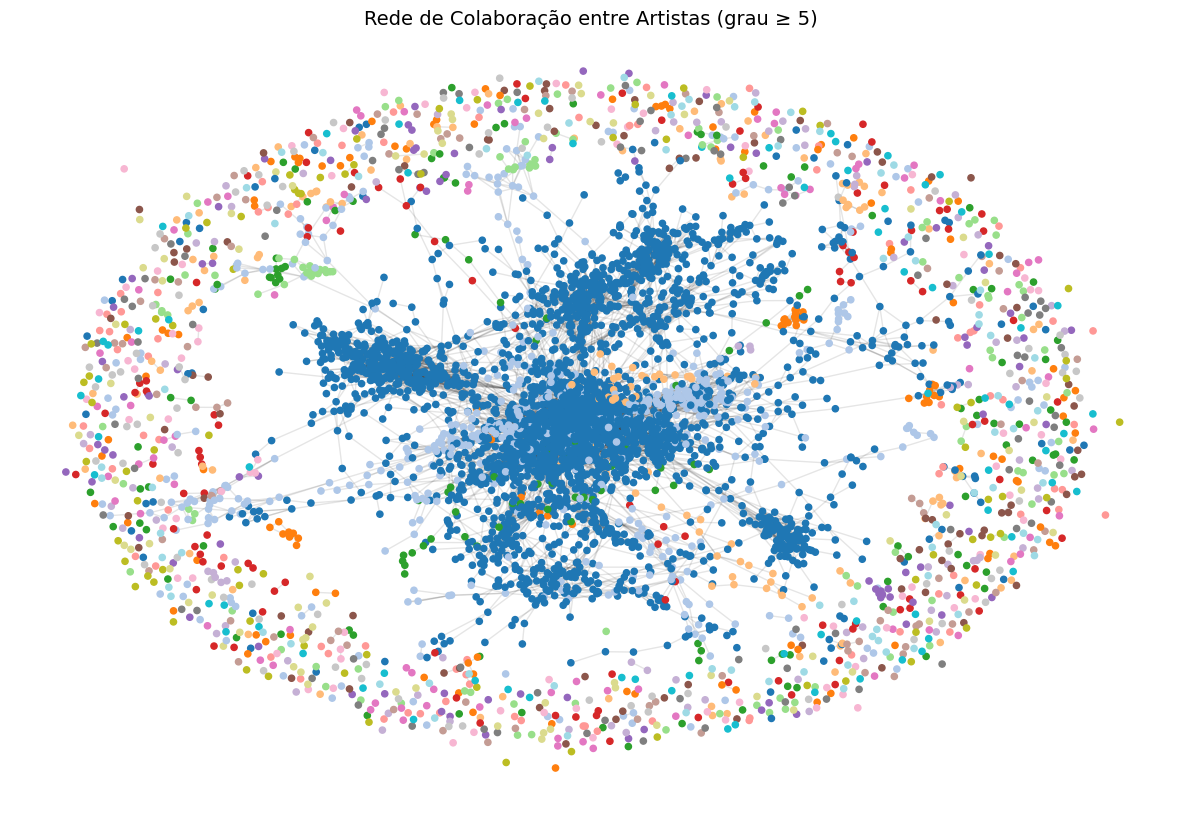

In [ ]:
# Detecta comunidades no grafo filtrado
comunidades = community_louvain.best_partition(G_sub)
cores = [comunidades[n] for n in G_sub.nodes()]

# Layout por força
pos = nx.spring_layout(G_sub, k=0.5, seed=42)

# Desenha o grafo
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(G_sub, pos, node_color=cores, node_size=20, cmap=plt.cm.tab20)
nx.draw_networkx_edges(G_sub, pos, alpha=0.1)

plt.title("Rede de Colaboração entre Artistas (grau ≥ 5)", fontsize=14)
plt.axis('off')

# Salvar figura
plt.savefig("grafo_colaboracoes.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Filtrar grafo para artistas com grau >= 50
sub_nodes2 = [n for n, d in G.degree() if d >= 50]
G_sub2 = G.subgraph(sub_nodes2)
print(f"Grafo filtrado: {G_sub2.number_of_nodes()} nós, {G_sub2.number_of_edges()} arestas")

Grafo filtrado: 32 nós, 97 arestas


In [ ]:
net = Network(height='600px', width='100%', notebook=True, bgcolor='#222222', font_color='white')
net.from_nx(G_sub2)
net.show('rede_colaboracoes.html')

# Deve-se fazer o download de rede_colaboracoes.html e abrir no navegador.

rede_colaboracoes.html


## Arestas com maior peso (colaborações mais frequentes)

In [ ]:
pesos = nx.get_edge_attributes(G, 'weight')
top_pares = sorted(pesos.items(), key=lambda x: x[1], reverse=True)[:20]
print("Top 20 parcerias mais frequentes:")
for (a1, a2), w in top_pares:
  print(f"{a1} ↔ {a2}: {w} músicas juntos")

Top 20 parcerias mais frequentes:
Genius Brasil Tradues ↔ Genius Brasil Traduções: 889 músicas juntos
Genius Traducciones Al Espaol ↔ Genius Traducciones Al Español: 680 músicas juntos
Genius Traductions Franaises ↔ Genius Traductions Françaises: 463 músicas juntos
Genius Trke Eviri ↔ Genius Türkçe Çeviri: 404 músicas juntos
Genius Russian Translations ( ) ↔ Genius Russian Translations (Русский Перевод): 328 músicas juntos
Genius Deutsche Bersetzungen ↔ Genius Deutsche Übersetzungen: 173 músicas juntos
Polskie Tumaczenia Genius ↔ Polskie Tłumaczenia Genius: 138 músicas juntos
La Bible De Jrusalem ↔ La Bible De Jérusalem: 118 músicas juntos
Genius Farsi Translations ( ) ↔ Genius Farsi Translations (ترجمه‌ی فارسی): 117 músicas juntos
  (Leo Tolstoy) ↔ Лев Толстой (Leo Tolstoy): 91 músicas juntos
Nat "King" Cole ↔ Nat \\\"King\\\" Cole: 82 músicas juntos
Motrhead ↔ Motörhead: 58 músicas juntos
The Fall ↔ ​The Fall: 52 músicas juntos
Die Rzte ↔ Die Ärzte: 50 músicas juntos
Roco Jurado ↔ Ro

## Componentes principais

In [ ]:
componentes = sorted(nx.connected_components(G), key=len, reverse=True)
print(f"Maior componente tem {len(componentes[0])} artistas")

# Extrair subgrafo da maior componente
G_maior = G.subgraph(componentes[0])

Maior componente tem 39523 artistas


## Centralidade de Grau e Betweenness

In [ ]:
centralidade = nx.degree_centrality(G)
top_central = sorted(centralidade.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top artistas por centralidade de grau:")
for nome, val in top_central:
  print(f"{nome}: {val:.4f}")

Top artistas por centralidade de grau:
Walt Disney Records: 0.0010
Gucci Mane: 0.0009
Various Artists: 0.0008
Lil Wayne: 0.0008
Snoop Dogg: 0.0007
The Game: 0.0007
Chris Brown: 0.0006
初音ミク (Hatsune Miku): 0.0006
E-40: 0.0006
Young Thug: 0.0006
